In [47]:
import numpy as np, pathlib
import cv2
from matplotlib import pyplot as plt
from skimage.filters import threshold_local, threshold_otsu, rank
from skimage.feature.peak import peak_local_max
from skimage.morphology import disk
from scipy.ndimage import label
import mahotas as mh
%matplotlib inline

In [2]:
from skimage import exposure

In [3]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

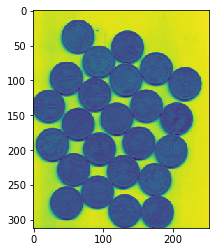

In [132]:
img = cv2.imread('water_coins.jpg')
#gray = cv2.imread(r'C:/Users/mymmp/OneDrive/Work_Notes/OBI/CV-Images/ImageProcessing/2.ImageBreaker/tiles_output/HCells_FOV72/FOV72_DAPI_tile-x0y3.png')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
plt.imshow(gray)

Text(0.5, 1.0, 'unknow')

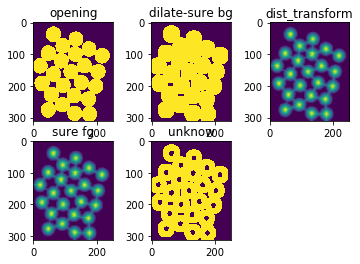

In [126]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 3); 
plt.subplot(231); plt.imshow(opening); plt.title('opening')

# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)
plt.subplot(232); plt.imshow(sure_bg); plt.title('dilate-sure bg')

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 0)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(), 255, 0)
plt.subplot(233); plt.imshow(dist_transform); plt.title('dist_transform')
plt.subplot(234); plt.imshow(dist_transform); plt.title('sure fg')

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
plt.subplot(235); plt.imshow(unknown); plt.title('unknow')

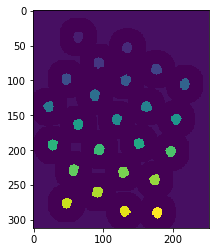

In [127]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0
plt.imshow(markers)

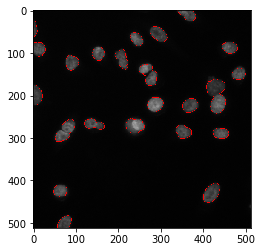

In [20]:
markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]
plt.imshow(img)

In [4]:
pathlib.Path(r'C:\Users\Mo\OneDrive\Work_Notes\OBI\CV-Images\ImageProcessing\2.ImageBreaker\tiles_output\HCells_FOV72')

WindowsPath('C:/Users/Mo/OneDrive/Work_Notes/OBI/CV-Images/ImageProcessing/2.ImageBreaker/tiles_output/HCells_FOV72')

<b> Cells

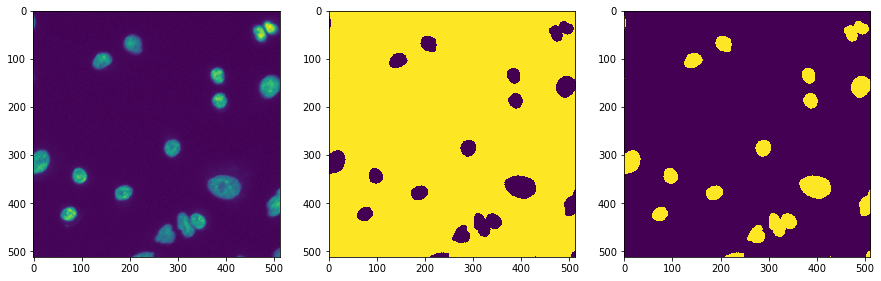

In [133]:
#img = cv2.imread(r'C:/Users/mymmp/OneDrive/Work_Notes/OBI/CV-Images/ImageProcessing/2.ImageBreaker/tiles_output/HCells_FOV72/FOV72_DAPI_tile-x0y2.png')
img = cv2.imread(r'C:/Users/Mo/OneDrive/Work_Notes/OBI/CV-Images/ImageProcessing/2.ImageBreaker/tiles_output/HCells_FOV72/FOV72_DAPI_tile-x0y3.png')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
adapt_thresh = (((threshold_local(gray, block_size=5) > threshold_otsu(gray))!=0)*255).astype('uint8')
plt.figure(figsize=(15,5)); plt.subplot(131);plt.imshow(gray)
plt.subplot(132);plt.imshow(thresh) # Basic
plt.subplot(133);plt.imshow(adapt_thresh) # adaptive

In [164]:
# noise removal
@interact(kernel_size=(1,10,1), dilate_iteration = (1, 50, 1), dist_threshold = (0, 1, 0.05),
          dist_blur=(1,20,1), adapt_block_size=(1,51,2), adapt_offset=(1,255,2))
def plot_watershed(kernel_size=3, dilate_iteration=1, dist_threshold=0.7, dist_blur=3, adapt_block_size = 19, adapt_offset = 100):
    opening = adapt_thresh
    plt.figure(figsize=(15,15)); plt.subplot(339); plt.imshow(img); plt.title('Original')
    #plt.subplot(331); plt.imshow(opening); plt.title('opening')

    # sure background area
    kernel = np.ones((kernel_size,kernel_size), np.uint8)
    sure_bg = cv2.dilate(opening, kernel, iterations=dilate_iteration)
    plt.subplot(331); plt.imshow(opening); plt.title('dilate-sure bg')

    # Finding sure foreground area
    dist_transform = mh.stretch(cv2.distanceTransform(opening, cv2.DIST_L2, 0))
    #dist_transform = mh.stretch(exposure.adjust_log(dist_threshold))
    #print(dist_transform.min(), dist_transform.max())
    
    # for method 2 
    #dist_transform = rank.mean(dist_transform, disk(dist_blur))
    local_maxi = peak_local_max(dist_transform, indices=False, footprint=np.ones((60, 60)), labels=gray, threshold_rel=0.4)
    peak_markers = label(local_maxi)[0]
    plt.subplot(335); plt.imshow(local_maxi); plt.title('Peak markers (method 2)')
    #
    sure_fg = ((threshold_local(dist_transform, block_size=adapt_block_size, offset=adapt_offset, method='gaussian', mode='mirror') > dist_transform.mean())!= 0)*255
    #ret, sure_fg = cv2.threshold(dist_transform, dist_threshold*dist_transform.max(), 255, 0)
    plt.subplot(332); plt.imshow(dist_transform); plt.title('dist_transform')
    plt.subplot(333); plt.imshow(sure_fg); plt.title('sure fg')

    # Finding unknown region
    sure_fg = np.uint8(sure_fg); unknown = cv2.subtract(sure_bg,sure_fg)
    plt.subplot(334); plt.imshow(unknown); plt.title('unknown')
    
    # Marker labelling (Method 1)
    ret, markers = cv2.connectedComponents(sure_fg)
    # Add one to all labels so that sure background is not 0, but 1
    markers = markers+1; markers[unknown==255] = 0
    plt.subplot(336); plt.imshow(markers); plt.title('Method 1')
    
    markers1 = cv2.watershed(img, markers); img1 = img.copy(); img1[markers1 == -1] = [255,0,0]
    plt.subplot(337); plt.imshow(cv2.bitwise_and(img1,img1,mask = adapt_thresh)); plt.title("Segment 1")
    
    markers2 = cv2.watershed(img, peak_markers) 
    img2 = img.copy(); img2[markers2 == -1] = [255,0,0]
    plt.subplot(338); plt.imshow(img2); plt.title("Segment 2")
    
    
    # See boundary
    plt.figure(figsize=(15,7))
    plt.subplot(121); plt.imshow(markers1==-1); plt.title('Marker 1')
    plt.subplot(122); plt.imshow(markers2==-1); plt.title('Marker 2')
    return markers1, markers2

interactive(children=(IntSlider(value=3, description='kernel_size', max=10, min=1), IntSlider(value=1, descrip…

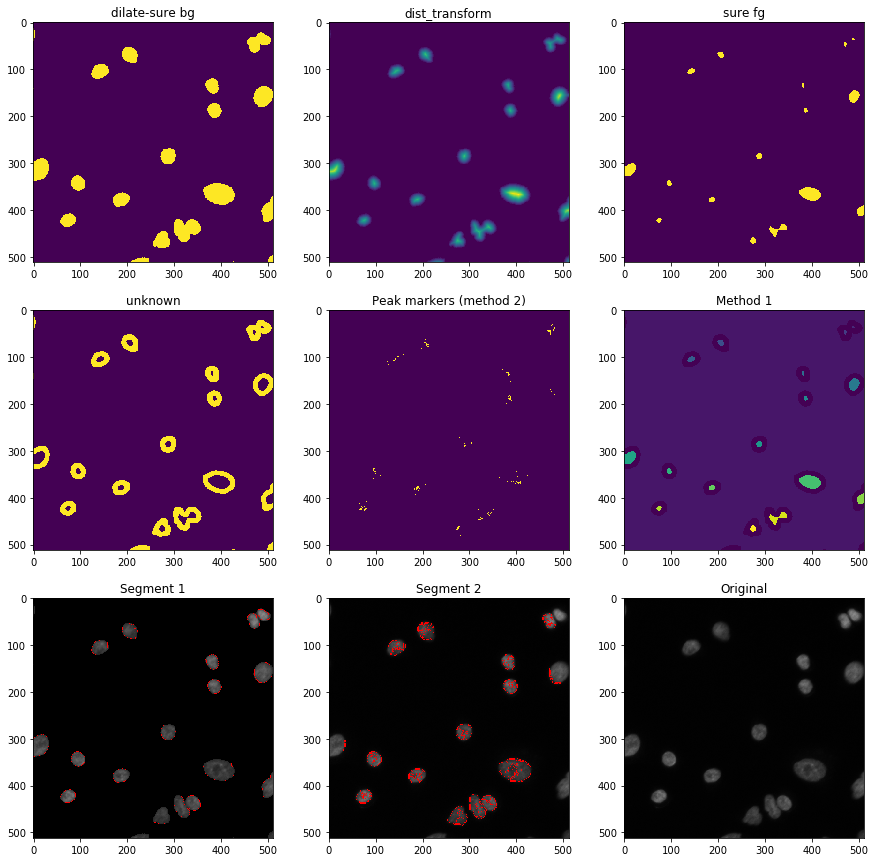

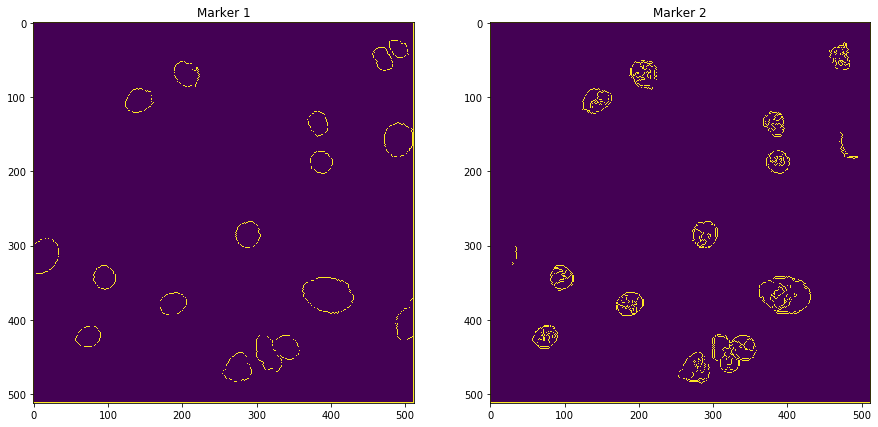

In [233]:
markers1, markers2 = plot_watershed(kernel_size=3, dilate_iteration=1, dist_threshold=0.7, dist_blur=3, \
                                    adapt_block_size = 19, adapt_offset = 100)

<b> Optional

In [218]:
sizes = mh.labeled.labeled_size(markers1)
labels = mh.labeled.remove_regions_where(markers1, sizes < 16**2)

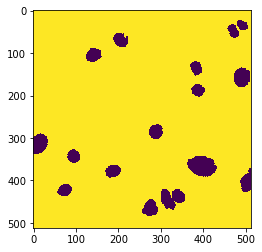

In [234]:
plt.imshow(markers1==1)